# Dominoes Project : Predictive Purchase Order System


# Part 2 : Model Building and Prediction

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
dfs = pd.read_excel('Pizza_Sale_Cleaned.xlsx')
dfs.head()

,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_name
0,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,The Hawaiian Pizza
1,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,The Classic Deluxe Pizza
2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,The Five Cheese Pizza
3,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,The Italian Supreme Pizza
4,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,The Mexicana Pizza


In [6]:
dfs['pizza_name_id'] = dfs['pizza_name_id'].str.lower()

In [7]:
dfs['order_date'] = pd.to_datetime(dfs['order_date'])
df_agg = dfs.groupby(['order_date', 'pizza_name_id']).agg({'quantity': 'sum',}).reset_index()
df_agg

,order_date,pizza_name_id,quantity
0,2015-01-01,bbq_ckn_l,6
1,2015-01-01,bbq_ckn_m,4
2,2015-01-01,bbq_ckn_s,1
3,2015-01-01,big_meat_s,5
4,2015-01-01,calabrese_m,1
...,...,...,...
22959,2015-12-31,the_greek_l,1
22960,2015-12-31,the_greek_xl,1
22961,2015-12-31,veggie_veg_l,4
22962,2015-12-31,veggie_veg_m,2


In [8]:
df_agg.isna().sum()

order_date       0
pizza_name_id    0
quantity         0
dtype: int64

## Outlier Removal
#### Try with and without
#### First let's remove it and store in a variable to see 

In [8]:
df_agg.describe()

,order_date,quantity
count,22964,22964.000000
mean,2015-06-30 01:39:04.608953088,2.158770
min,2015-01-01 00:00:00,1.000000
25%,2015-03-31 00:00:00,1.000000
50%,2015-06-30 00:00:00,2.000000
75%,2015-09-30 00:00:00,3.000000
max,2015-12-31 00:00:00,15.000000
std,NaN,1.436352


In [104]:
# Calculate Z-scores for the 'quantity' column
df_agg['z_score'] = (df_agg['quantity'] - df_agg['quantity'].mean()) / df_agg['quantity'].std()

# Filter out outliers based on Z-score threshold of 3
threshold = 3
df_filtered = df_agg[np.abs(df_agg['z_score']) <= threshold]
df_outliers = df_agg[np.abs(df_agg['z_score']) > threshold]

# Drop the z_score column as it's no longer needed
df_filtered = df_filtered.drop(columns=['z_score'])
df_outliers = df_outliers.drop(columns=['z_score'])
df_agg = df_agg.drop(columns=['z_score'])

print(f"Original DataFrame shape: {df_agg.shape}")
print(f"Outliers DataFrame shape: {df_outliers.shape}")
print(f"Filtered DataFrame shape: {df_filtered.shape}")


Original DataFrame shape: (22964, 3)
Outliers DataFrame shape: (359, 3)
Filtered DataFrame shape: (22605, 3)


In [105]:
df_outliers.describe()

,quantity
count,359.000000
mean,7.908078
std,1.311708
min,7.000000
25%,7.000000
50%,7.000000
75%,8.000000
max,15.000000


In [106]:
df_filtered.describe()

,quantity
count,22605.000000
mean,2.067463
std,1.239076
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,6.000000


In [49]:
df_outliers['quantity'].sum()

2839

In [50]:
df_filtered.head(1)

,order_date,pizza_name_id,quantity
0,2015-01-01,bbq_ckn_l,6


In [75]:
def extra_features_from_date(df):
    df['day_of_week'] = df['order_date'].dt.weekday +1 #Starts with 1 as Monday to 7 as Sunday
    df['day_of_year'] = df['order_date'].dt.dayofyear 
    df['day_of_month'] = df['order_date'].dt.day
    df['week_of_year'] = df['order_date'].dt.strftime('%W') #week starts on Monday, new year days preceeding the first monday is week 0
    df['month'] = df['order_date'].dt.month    
    return df


In [83]:
extra_features_from_date(df_filtered)

,order_date,pizza_size,pizza_name,unit_price,quantity,pizza_name_id,pizza_category,day_of_week,day_of_year,day_of_month,week_of_year,month
0,2015-01-01,L,The Barbecue Chicken Pizza,20.75,6,bbq_ckn_l,Chicken,4,1,1,00,1
1,2015-01-01,L,The California Chicken Pizza,20.75,2,cali_ckn_l,Chicken,4,1,1,00,1
2,2015-01-01,L,The Chicken Pesto Pizza,20.75,3,ckn_pesto_l,Chicken,4,1,1,00,1
3,2015-01-01,L,The Classic Deluxe Pizza,20.50,1,classic_dlx_l,Classic,4,1,1,00,1
5,2015-01-01,L,The Four Cheese Pizza,17.95,3,four_cheese_l,Veggie,4,1,1,00,1
...,...,...,...,...,...,...,...,...,...,...,...,...
22744,2015-12-31,S,The Spicy Italian Pizza,12.50,3,spicy_ital_s,Supreme,4,365,31,52,12
22745,2015-12-31,S,The Spinach Pesto Pizza,12.50,2,spin_pesto_s,Veggie,4,365,31,52,12
22746,2015-12-31,S,The Spinach and Feta Pizza,12.00,3,spinach_fet_s,Veggie,4,365,31,52,12
22747,2015-12-31,S,The Vegetables + Vegetables Pizza,12.00,4,veggie_veg_s,Veggie,4,365,31,52,12


In [85]:
df_filtered.drop(['order_date','pizza_name_id'],axis=1,inplace=True)

In [86]:
df_filtered.head(1)

,pizza_size,pizza_name,unit_price,quantity,pizza_category,day_of_week,day_of_year,day_of_month,week_of_year,month
0,L,The Barbecue Chicken Pizza,20.75,6,Chicken,4,1,1,00,1


In [91]:
df_filtered.dtypes

pizza_size         object
pizza_name         object
unit_price        float64
quantity            int64
pizza_category     object
day_of_week         int32
day_of_year         int32
day_of_month        int32
week_of_year        int64
month               int32
dtype: object

In [90]:
df_filtered['week_of_year'] = df_filtered['week_of_year'].astype(int)

In [118]:
df_filtered.head(1)

,pizza_size,pizza_name,unit_price,quantity,pizza_category,day_of_week,day_of_year,day_of_month,week_of_year,month
0,L,The Barbecue Chicken Pizza,20.75,6,Chicken,4,1,1,0,1


In [99]:
# With Outliers: df_agg
# Without Outliers: df_filtered

## Classic ML regression models 

In [94]:
from sklearn.preprocessing import LabelEncoder


In [110]:
df_encoded = pd.get_dummies(df_filtered, columns=['pizza_name', 'pizza_category'], drop_first=False)


In [111]:
# Label Encoding
le = LabelEncoder()
df_encoded['pizza_size'] = le.fit_transform(df_encoded['pizza_size'])


In [112]:
df_encoded.head()

,pizza_size,unit_price,quantity,day_of_week,day_of_year,day_of_month,week_of_year,month,pizza_name_The Barbecue Chicken Pizza,pizza_name_The Big Meat Pizza,...,pizza_name_The Spicy Italian Pizza,pizza_name_The Spinach Pesto Pizza,pizza_name_The Spinach Supreme Pizza,pizza_name_The Spinach and Feta Pizza,pizza_name_The Thai Chicken Pizza,pizza_name_The Vegetables + Vegetables Pizza,pizza_category_Chicken,pizza_category_Classic,pizza_category_Supreme,pizza_category_Veggie
0,0,20.75,6,4,1,1,0,1,True,False,...,False,False,False,False,False,False,True,False,False,False
1,0,20.75,2,4,1,1,0,1,False,False,...,False,False,False,False,False,False,True,False,False,False
2,0,20.75,3,4,1,1,0,1,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0,20.50,1,4,1,1,0,1,False,False,...,False,False,False,False,False,False,False,True,False,False
5,0,17.95,3,4,1,1,0,1,False,False,...,False,False,False,False,False,False,False,False,False,True


In [115]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df_encoded.drop('quantity', axis=1)  # Features
y = df_encoded['quantity']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Train models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained.')


Linear Regression trained.
Decision Tree trained.
Random Forest trained.
Gradient Boosting trained.


In [117]:
# Make predictions and evaluate each model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

# Display results
for name, metrics in results.items():
    print(f'\n{name} Metrics:')
    for metric, value in metrics.items():
        print(f'{metric}: {value:.4f}')



Linear Regression Metrics:
MSE: 1.2809
RMSE: 1.1318
MAE: 0.8949
R2: 0.1725

Decision Tree Metrics:
MSE: 2.4545
RMSE: 1.5667
MAE: 1.1236
R2: -0.5858

Random Forest Metrics:
MSE: 1.3202
RMSE: 1.1490
MAE: 0.8988
R2: 0.1470

Gradient Boosting Metrics:
MSE: 1.2145
RMSE: 1.1021
MAE: 0.8720
R2: 0.2153


### This is okay but in order to predict 91 pizza_types and for next 7 days would take a lot of time, thus we will look into another model that is more capable of dealing with time series problems

## LSTM

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [10]:
df_agg.head()

,order_date,pizza_name_id,quantity
0,2015-01-01,bbq_ckn_l,6
1,2015-01-01,bbq_ckn_m,4
2,2015-01-01,bbq_ckn_s,1
3,2015-01-01,big_meat_s,5
4,2015-01-01,calabrese_m,1


In [9]:

df_agg['order_date'] = pd.to_datetime(df_agg['order_date'], format='%Y-%m-%d')

data = pd.pivot_table(
           data    = df_agg,
           values  = 'quantity',
           index   = 'order_date',
           columns = 'pizza_name_id'
       )
data.columns.name = None
data.columns = [f"{col}" for col in data.columns]
data = data.asfreq('1D')
data = data.sort_index()
data.head(4)

,bbq_ckn_l,bbq_ckn_m,bbq_ckn_s,big_meat_s,brie_carre_s,calabrese_l,calabrese_m,calabrese_s,cali_ckn_l,cali_ckn_m,...,thai_ckn_m,thai_ckn_s,the_greek_l,the_greek_m,the_greek_s,the_greek_xl,the_greek_xxl,veggie_veg_l,veggie_veg_m,veggie_veg_s
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,6.0,4.0,1.0,5.0,NaN,NaN,1.0,NaN,2.0,1.0,...,2.0,NaN,NaN,NaN,4.0,1.0,NaN,1.0,NaN,2.0
2015-01-02,4.0,7.0,1.0,9.0,3.0,2.0,5.0,NaN,4.0,9.0,...,1.0,1.0,1.0,1.0,NaN,2.0,NaN,1.0,NaN,NaN
2015-01-03,2.0,NaN,NaN,3.0,1.0,NaN,1.0,NaN,1.0,4.0,...,NaN,2.0,NaN,1.0,1.0,1.0,NaN,3.0,1.0,2.0
2015-01-04,NaN,2.0,NaN,3.0,NaN,1.0,1.0,NaN,2.0,1.0,...,1.0,NaN,NaN,2.0,2.0,2.0,NaN,NaN,2.0,3.0


In [10]:
data.fillna(0, inplace=True)

In [11]:
data.head(4)

,bbq_ckn_l,bbq_ckn_m,bbq_ckn_s,big_meat_s,brie_carre_s,calabrese_l,calabrese_m,calabrese_s,cali_ckn_l,cali_ckn_m,...,thai_ckn_m,thai_ckn_s,the_greek_l,the_greek_m,the_greek_s,the_greek_xl,the_greek_xxl,veggie_veg_l,veggie_veg_m,veggie_veg_s
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,6.0,4.0,1.0,5.0,0.0,0.0,1.0,0.0,2.0,1.0,...,2.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,2.0
2015-01-02,4.0,7.0,1.0,9.0,3.0,2.0,5.0,0.0,4.0,9.0,...,1.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0
2015-01-03,2.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,1.0,4.0,...,0.0,2.0,0.0,1.0,1.0,1.0,0.0,3.0,1.0,2.0
2015-01-04,0.0,2.0,0.0,3.0,0.0,1.0,1.0,0.0,2.0,1.0,...,1.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,3.0


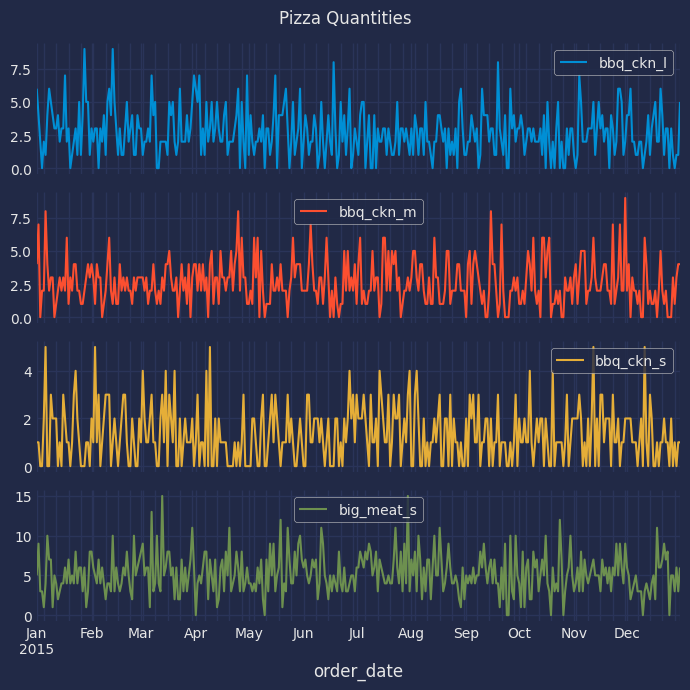

In [11]:
import skforecast
from skforecast.plot import set_dark_theme

# Plot time series for first 4 pizzas alone 
# ======================================================================================
set_dark_theme()
fig, axs = plt.subplots(4, 1, figsize=(7, 7), sharex=True)
data.iloc[:, :4].plot(
    legend   = True,
    subplots = True, 
    title    = 'Pizza Quantities',
    ax       = axs, 
)
fig.tight_layout()
plt.show()

In [50]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Define sequence length
sequence_length = 7

# Split data into train and test sets
def train_test_split_sequences(data, sequence_length, test_size=0.2):
    n = len(data)
    split_idx = int(n * (1 - test_size))
    
    train_data = data[:split_idx]
    test_data = data[split_idx:]
    
    return train_data, test_data

# Function to create sequences
def create_sequences(data, sequence_length):
    generator = TimeseriesGenerator(data, data, length=sequence_length, batch_size=1)
    return generator

# Function to define and train LSTM model
def train_lstm_model(train_data, sequence_length):
    generator = create_sequences(train_data, sequence_length)
    
    model = Sequential([
        LSTM(32, activation='relu', input_shape=(sequence_length, train_data.shape[1])),
        Dense(train_data.shape[1])
    ])
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(generator, epochs=20, verbose=1)
    
    return model


def predict_next_7_days(model, data, sequence_length, scaler):
    predictions = []
    recent_data = data[-sequence_length:]
    
    for _ in range(7):
        input_sequence = np.expand_dims(recent_data, axis=0)  # Shape: (1, sequence_length, number_of_features)
        pred_scaled = model.predict(input_sequence)
        pred = scaler.inverse_transform(pred_scaled.reshape(-1, pred_scaled.shape[-1]))  # Reshape for inverse_transform
        predictions.append(pred[-1])  # Append the last prediction
        
        # Update the recent data with the new prediction
        recent_data = np.append(recent_data[1:], np.expand_dims(pred_scaled[0], axis=0), axis=0)
    
    return np.array(predictions)
    
# Train-test split
train_data, test_data = train_test_split_sequences(scaled_data, sequence_length)

# Train the model
model = train_lstm_model(train_data, sequence_length)

Epoch 1/20


/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


191/285 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.0642

/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - loss: 0.0592
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.0406
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.0403
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.0397
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.0395
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.0387
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 0.0382
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.0378
Epoch 9/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 0.0375
Epoch 10/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.0374
Epoch 11/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.0373
Epoch 12/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 0.0363
Epoch 13/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0363
Epoch 14/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 0.0367
Epoch 15/20
285/285 ━━━━━━━━━━━━━━━━━━━━

In [51]:
# Function to create sequences for test data
def create_sequences_for_test(data, sequence_length):
    generator = TimeseriesGenerator(data, data, length=sequence_length, batch_size=1, shuffle=False)
    return generator

# Create sequences for test data
test_generator = create_sequences_for_test(test_data, sequence_length)


In [52]:
# Get true values and predictions
def get_predictions_and_true_values(model, generator):
    true_values = []
    predictions = []
    
    for i in range(len(generator)):
        X, y = generator[i]
        y_pred = model.predict(X)
        
        true_values.append(y.flatten())
        predictions.append(y_pred.flatten())
    
    return np.array(true_values), np.array(predictions)

true_values, predictions = get_predictions_and_true_values(model, test_generator)

# Calculate MSE and MAE
mse = mean_squared_error(true_values, predictions)
mae = mean_absolute_error(true_values, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [53]:
# Inverse transform to original scale if needed
true_values_original = scaler.inverse_transform(true_values)
predictions_original = scaler.inverse_transform(predictions)

round_predictions = np.round(predictions_original).astype(int)

# Recalculate MSE and MAE in the original scale
mse_original = mean_squared_error(true_values_original, round_predictions)
mae_original = mean_absolute_error(true_values_original, round_predictions)

print(f'Original Scale Mean Squared Error (MSE): {mse_original}')
print(f'Original Scale Mean Absolute Error (MAE): {mae_original}')

Original Scale Mean Squared Error (MSE): 1.9312354312354314
Original Scale Mean Absolute Error (MAE): 0.9771894771894774


In [54]:
round_predictions

array([[3, 1, 1, ..., 1, 1, 1],
       [3, 2, 2, ..., 2, 1, 1],
       [3, 1, 1, ..., 2, 1, 2],
       ...,
       [3, 2, 1, ..., 1, 1, 1],
       [3, 2, 2, ..., 1, 1, 1],
       [3, 2, 2, ..., 1, 2, 1]])

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Hyper parameter tuning 

# Define sequence length
# Function to create sequences
def create_sequences(data, sequence_length):
    generator = TimeseriesGenerator(data, data, length=sequence_length, batch_size=1)
    return generator

# Function to create sequences for test data
def create_sequences_for_test(data, sequence_length):
    generator = TimeseriesGenerator(data, data, length=sequence_length, batch_size=1, shuffle=False)
    return generator


# Function to define and train LSTM model
def train_lstm_model1(train_data, sequence_length,unit):
    generator = create_sequences(train_data, sequence_length)
    
    model = Sequential([
        LSTM(unit, activation='relu', input_shape=(sequence_length, train_data.shape[1])),
        Dense(train_data.shape[1])
    ])
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(generator, epochs=20, verbose=1)
    
    return model

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Split data into train and test sets
def train_test_split_sequences(data, sequence_length, test_size=0.2):
    n = len(data)
    split_idx = int(n * (1 - test_size))
    
    train_data = data[:split_idx]
    test_data = data[split_idx:]
    
    return train_data, test_data

# Get true values and predictions
def get_predictions_and_true_values(model, generator):
    true_values = []
    predictions = []
    
    for i in range(len(generator)):
        X, y = generator[i]
        y_pred = model.predict(X)
        
        true_values.append(y.flatten())
        predictions.append(y_pred.flatten())
    
    return np.array(true_values), np.array(predictions)

sequence_length = [7,14,30]
units = [32,64,128,256 ]

for s in sequence_length:
    for i in units:

    
        train_data, test_data = train_test_split_sequences(scaled_data, s)
        
        # Train the modeloaded_mo
        model = train_lstm_model1(train_data, s,i)
        
        
        # Create sequences for test data
        test_generator = create_sequences_for_test(test_data, s)
        
        
        true_values, predictions = get_predictions_and_true_values(model, test_generator)
        
        # Calculate MSE and MAE
        mse = mean_squared_error(true_values, predictions)
        mae = mean_absolute_error(true_values, predictions)

        print(f'Sequence length : {s}')
        print(f'LSTM Unit size  : {i}')
        print(f'Mean Squared Error (MSE): {mse}')
        print(f'Mean Absolute Error (MAE): {mae}')
        
        
        # Inverse transform to original scale if needed
        true_values_original = scaler.inverse_transform(true_values)
        predictions_original = scaler.inverse_transform(predictions)
        
        round_predictions = np.round(predictions_original).astype(int)
        
        # Recalculate MSE and MAE in the original scale
        mse_original = mean_squared_error(true_values_original, round_predictions)
        mae_original = mean_absolute_error(true_values_original, round_predictions)
        
        print(f'Original Scale Mean Squared Error (MSE): {mse_original}')
        print(f'Original Scale Mean Absolute Error (MAE): {mae_original}')
        

Epoch 1/20


/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 79/285 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0760

/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0581
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0405
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 0.0399
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0407
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 0.0396
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 0.0390
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.0381
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.0383
Epoch 9/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 0.0381
Epoch 10/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 0.0382
Epoch 11/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 0.0368
Epoch 12/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 0.0363
Epoch 13/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.0358
Epoch 14/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 0.0359
Epoch 15/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 98

/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0696  

/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0575
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0398
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0399
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0391
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0388
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0373
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0372
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0376
Epoch 9/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0359
Epoch 10/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0353
Epoch 11/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0347
Epoch 12/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0332
Epoch 13/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0330
Epoch 14/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0318
Epoch 15/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320


/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 86/285 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0542  

/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0476
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0411
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0401
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0402
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0379
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0385
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0369
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0355
Epoch 9/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0352
Epoch 10/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0320
Epoch 11/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0319
Epoch 12/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0310
Epoch 13/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0295
Epoch 14/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0278
Epoch 15/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0273


/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 24/285 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0756

/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0488
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0413
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0394
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0394
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0389
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0382
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0363
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0356
Epoch 9/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0339
Epoch 10/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0315
Epoch 11/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0296
Epoch 12/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0279
Epoch 13/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0259
Epoch 14/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0241
Epoch 15/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0223


/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0783  

/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0619
Epoch 2/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0412
Epoch 3/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0407
Epoch 4/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0395
Epoch 5/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0389
Epoch 6/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0389
Epoch 7/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0377
Epoch 8/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0387
Epoch 9/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0379
Epoch 10/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0379
Epoch 11/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0381
Epoch 12/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0365
Epoch 13/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0362
Epoch 14/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0353
Epoch 15/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0352


/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 81/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0657  

/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0532
Epoch 2/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0409
Epoch 3/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0407
Epoch 4/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0393
Epoch 5/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0412
Epoch 6/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0383
Epoch 7/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0382
Epoch 8/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0379
Epoch 9/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0374
Epoch 10/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0360
Epoch 11/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0362
Epoch 12/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0350
Epoch 13/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0341
Epoch 14/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0334
Epoch 15/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0328


/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 45/278 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0646  

/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0492
Epoch 2/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0409
Epoch 3/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0415
Epoch 4/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0383
Epoch 5/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0386
Epoch 6/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0391
Epoch 7/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0366
Epoch 8/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0364
Epoch 9/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0356
Epoch 10/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0339
Epoch 11/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0327
Epoch 12/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0307
Epoch 13/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0305
Epoch 14/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0299
Epoch 15/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0281


/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 28/278 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0652

/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0481
Epoch 2/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0413
Epoch 3/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0399
Epoch 4/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0401
Epoch 5/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0385
Epoch 6/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0381
Epoch 7/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0367
Epoch 8/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0362
Epoch 9/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0332
Epoch 10/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0326
Epoch 11/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0309
Epoch 12/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0298
Epoch 13/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0271
Epoch 14/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0260
Epoch 15/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0241


/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 68/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0795  

/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0599
Epoch 2/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0408
Epoch 3/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0394
Epoch 4/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0398
Epoch 5/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0393
Epoch 6/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0383
Epoch 7/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0381
Epoch 8/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0384
Epoch 9/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0384
Epoch 10/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0377
Epoch 11/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0371
Epoch 12/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0355
Epoch 13/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0366
Epoch 14/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0362
Epoch 15/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0352


/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 51/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0840  

/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0570
Epoch 2/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0423
Epoch 3/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0403
Epoch 4/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0404
Epoch 5/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0388
Epoch 6/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0381
Epoch 7/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0381
Epoch 8/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0379
Epoch 9/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0369
Epoch 10/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0365
Epoch 11/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0362
Epoch 12/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0345
Epoch 13/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0343
Epoch 14/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0337
Epoch 15/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0326


/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 28/262 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0725

/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0498
Epoch 2/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0406
Epoch 3/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0399
Epoch 4/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0392
Epoch 5/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0382
Epoch 6/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0381
Epoch 7/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0376
Epoch 8/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0360
Epoch 9/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0345
Epoch 10/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0330
Epoch 11/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0322
Epoch 12/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0305
Epoch 13/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0303
Epoch 14/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0276
Epoch 15/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0272


/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 16/262 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0821

/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0486
Epoch 2/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0407
Epoch 3/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0394
Epoch 4/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0393
Epoch 5/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0382
Epoch 6/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0390
Epoch 7/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0357
Epoch 8/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0351
Epoch 9/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0346
Epoch 10/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0315
Epoch 11/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0292
Epoch 12/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0275
Epoch 13/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0257
Epoch 14/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0238
Epoch 15/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step 

In [60]:
# save model 
model.save("lstm_pizza_model.keras")

## Pizza quantities predictions for next 7 days and it's ingridients quantity in grams as well

In [61]:
from tensorflow.keras.models import load_model

data = pd.read_excel('data_time_series.xlsx', index_col=0)
data.head()

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Define sequence length
sequence_length = 7

loaded_model = load_model("lstm_pizza_model.keras")

def predict_next_7_days(model, data, sequence_length, scaler):
    predictions = []
    recent_data = data[-sequence_length:]
    
    for _ in range(7):
        input_sequence = np.expand_dims(recent_data, axis=0)  # Shape: (1, sequence_length, number_of_features)
        pred_scaled = model.predict(input_sequence)
        pred = scaler.inverse_transform(pred_scaled.reshape(-1, pred_scaled.shape[-1]))  # Reshape for inverse_transform
        predictions.append(pred[-1])  # Append the last prediction
        
        # Update the recent data with the new prediction
        recent_data = np.append(recent_data[1:], np.expand_dims(pred_scaled[0], axis=0), axis=0)
    
    return np.array(predictions)

/opt/anaconda3/envs/pizzaproj/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [64]:
# Predict for the next 7 days
test_predictions = predict_next_7_days(loaded_model, scaled_data, sequence_length, scaler)

print("Predictions for the next 7 days:", test_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predictions for the next 7 days: [[ 2.6355176e+00  1.7537613e+00  1.7666330e+00  5.5341644e+00
   1.1814649e+00  1.5174201e+00  8.6733031e-01  3.9141786e-01
   2.3274240e+00  2.9183025e+00  1.2585834e+00  1.4803524e-01
   2.1820722e+00  3.5896385e-01  7.5418067e-01  8.0369866e-01
   1.0575402e+00  1.2587126e+00  4.0918531e+00  2.3540034e+00
   3.6992073e+00  3.3481240e+00  1.7917469e+00  5.5395818e-01
   7.2756582e-01  1.6058552e+00  4.1292663e+00  1.4609780e+00
   2.6274123e+00  1.9955482e+00  1.3640611e+00  7.1346569e-01
   2.2936611e+00  3.5791187e+00  4.6545792e-01  4.5616278e-01
   1.1533172e+00  9.4946921e-01  9.8053330e-01  6.2107670e-01
   1.2635487e-01  2.5766242e+00  2.1175599e+00  5.0392711e-01
   9.6629977e-01  1.5072

In [65]:
# Round predictions to nearest integer
rounded_predictions = np.round(test_predictions).astype(int)

In [66]:
rounded_predictions

array([[3, 2, 2, 6, 1, 2, 1, 0, 2, 3, 1, 0, 2, 0, 1, 1, 1, 1, 4, 2, 4, 3,
        2, 1, 1, 2, 4, 1, 3, 2, 1, 1, 2, 4, 0, 0, 1, 1, 1, 1, 0, 3, 2, 1,
        1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 3,
        1, 1, 4, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 5, 1, 2, 1, 1, 1, 2, 0,
        1, 2, 1],
       [2, 2, 2, 5, 1, 1, 1, 0, 2, 2, 1, 0, 2, 0, 1, 1, 1, 1, 3, 2, 3, 3,
        2, 0, 1, 2, 3, 1, 3, 2, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3,
        1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1],
       [2, 2, 2, 5, 1, 1, 1, 0, 3, 2, 2, 0, 2, 0, 1, 1, 1, 1, 4, 2, 4, 3,
        2, 0, 1, 2, 3, 1, 2, 2, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3,
        2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 2, 0,
        1, 1, 1],
       [2, 2, 2, 5, 1, 1, 1, 0, 3, 2, 2, 1, 2, 0, 1, 1, 1,

In [67]:
# Now we got the 7 day predictions we need to convert to the show pizza_name
# And then calculate quantity of ingredients

In [68]:
data.head()

,bbq_ckn_l,bbq_ckn_m,bbq_ckn_s,big_meat_s,brie_carre_s,calabrese_l,calabrese_m,calabrese_s,cali_ckn_l,cali_ckn_m,...,thai_ckn_m,thai_ckn_s,the_greek_l,the_greek_m,the_greek_s,the_greek_xl,the_greek_xxl,veggie_veg_l,veggie_veg_m,veggie_veg_s
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,6,4,1,5,0,0,1,0,2,1,...,2,0,0,0,4,1,0,1,0,2
2015-01-02,4,7,1,9,3,2,5,0,4,9,...,1,1,1,1,0,2,0,1,0,0
2015-01-03,2,0,0,3,1,0,1,0,1,4,...,0,2,0,1,1,1,0,3,1,2
2015-01-04,0,2,0,3,0,1,1,0,2,1,...,1,0,0,2,2,2,0,0,2,3
2015-01-05,2,2,2,1,1,1,2,1,5,5,...,3,2,1,2,1,1,0,2,2,2


In [69]:
pizza_names = data.columns
pizza_names

Index(['bbq_ckn_l', 'bbq_ckn_m', 'bbq_ckn_s', 'big_meat_s', 'brie_carre_s',
       'calabrese_l', 'calabrese_m', 'calabrese_s', 'cali_ckn_l', 'cali_ckn_m',
       'cali_ckn_s', 'ckn_alfredo_l', 'ckn_alfredo_m', 'ckn_alfredo_s',
       'ckn_pesto_l', 'ckn_pesto_m', 'ckn_pesto_s', 'classic_dlx_l',
       'classic_dlx_m', 'classic_dlx_s', 'five_cheese_l', 'four_cheese_l',
       'four_cheese_m', 'green_garden_l', 'green_garden_m', 'green_garden_s',
       'hawaiian_l', 'hawaiian_m', 'hawaiian_s', 'ital_cpcllo_l',
       'ital_cpcllo_m', 'ital_cpcllo_s', 'ital_supr_l', 'ital_supr_m',
       'ital_supr_s', 'ital_veggie_l', 'ital_veggie_m', 'ital_veggie_s',
       'mediterraneo_l', 'mediterraneo_m', 'mediterraneo_s', 'mexicana_l',
       'mexicana_m', 'mexicana_s', 'napolitana_l', 'napolitana_m',
       'napolitana_s', 'pep_msh_pep_l', 'pep_msh_pep_m', 'pep_msh_pep_s',
       'pepperoni_l', 'pepperoni_m', 'pepperoni_s', 'peppr_salami_l',
       'peppr_salami_m', 'peppr_salami_s', 'prsc_argla

In [70]:
df_forecasted = pd.DataFrame(rounded_predictions, columns=pizza_names)

In [71]:
df_forecasted

,bbq_ckn_l,bbq_ckn_m,bbq_ckn_s,big_meat_s,brie_carre_s,calabrese_l,calabrese_m,calabrese_s,cali_ckn_l,cali_ckn_m,...,thai_ckn_m,thai_ckn_s,the_greek_l,the_greek_m,the_greek_s,the_greek_xl,the_greek_xxl,veggie_veg_l,veggie_veg_m,veggie_veg_s
0,3,2,2,6,1,2,1,0,2,3,...,1,2,1,1,1,2,0,1,2,1
1,2,2,2,5,1,1,1,0,2,2,...,1,1,0,1,1,1,0,1,1,1
2,2,2,2,5,1,1,1,0,3,2,...,1,1,1,1,1,2,0,1,1,1
3,2,2,2,5,1,1,1,0,3,2,...,1,1,1,1,1,1,0,1,1,1
4,2,2,2,5,1,1,1,0,3,2,...,1,1,1,1,1,1,0,1,1,1
5,3,2,2,5,1,1,1,0,3,2,...,1,1,1,1,1,1,0,1,1,1
6,3,2,1,5,1,1,1,0,3,2,...,1,1,1,1,1,1,0,1,1,1


In [73]:
max_date = data.index.max()
max_date

Timestamp('2015-12-31 00:00:00')

In [77]:
next_1_day = max_date + pd.Timedelta(days=1)
next_7_days = max_date + pd.Timedelta(days=7)


In [74]:
print(next_1_day)
print(next_7_days)

Timestamp('2016-01-07 00:00:00')

In [78]:
file_name = f"{next_1_day.strftime('%b%d')}_to_{next_7_days.strftime('%b%d')}_forecast.csv"


In [79]:
df_forecasted.to_csv(file_name, index=False)
print(f"File saved as: {file_name}")

File saved as: Jan01_to_Jan07_forecast.csv


In [80]:
df_forecast = pd.read_csv(file_name)
df_forecast

,bbq_ckn_l,bbq_ckn_m,bbq_ckn_s,big_meat_s,brie_carre_s,calabrese_l,calabrese_m,calabrese_s,cali_ckn_l,cali_ckn_m,...,thai_ckn_m,thai_ckn_s,the_greek_l,the_greek_m,the_greek_s,the_greek_xl,the_greek_xxl,veggie_veg_l,veggie_veg_m,veggie_veg_s
0,3,2,2,6,1,2,1,0,2,3,...,1,2,1,1,1,2,0,1,2,1
1,2,2,2,5,1,1,1,0,2,2,...,1,1,0,1,1,1,0,1,1,1
2,2,2,2,5,1,1,1,0,3,2,...,1,1,1,1,1,2,0,1,1,1
3,2,2,2,5,1,1,1,0,3,2,...,1,1,1,1,1,1,0,1,1,1
4,2,2,2,5,1,1,1,0,3,2,...,1,1,1,1,1,1,0,1,1,1
5,3,2,2,5,1,1,1,0,3,2,...,1,1,1,1,1,1,0,1,1,1
6,3,2,1,5,1,1,1,0,3,2,...,1,1,1,1,1,1,0,1,1,1


In [81]:
# Let's also create order with pizzas in each day
#and then also quantity in grams of each ingredient 
df_ing = pd.read_excel('Pizza_ingredients_cleaned.xlsx')
df_ing.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,pizza_size
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40,L
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15,L
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20,L
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30,L
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60,L


In [82]:
# Creating Order List for each day
for day, quantities in enumerate(rounded_predictions):
    order_list = []
    
    for i, quantity in enumerate(quantities):
        if quantity > 0:
            pizza_code = pizza_names[i]
            
            # Debug: Print pizza_code to check if it matches df_ing pizza_name_id
            #print(f"Pizza code: {pizza_code}")
            
            # Get pizza name and size from df_ing
            pizza_info = df_ing[df_ing['pizza_name_id'] == pizza_code]
            
            if pizza_info.empty:
                print(f"No match found for {pizza_code} in df_ing")
            else:
                pizza_name = pizza_info['pizza_name'].values[0]
                pizza_size = pizza_info['pizza_size'].values[0]
                
                # Add to order list
                order_list.append({
                    'Code': pizza_code,
                    'Pizza Name': pizza_name,
                    'Size': pizza_size,
                    'Quantity': quantity
                })
    
    # Convert the list of orders to a DataFrame for this day
    df_order = pd.DataFrame(order_list)
    
    # Display the order for the day as a table
    print(f"\nPizza Quantity Forecast for Day {day + 1}:\n")
    print(df_order.to_string(index=False))



Pizza Quantity Forecast for Day 1:

          Code                                 Pizza Name Size  Quantity
     bbq_ckn_l                 The Barbecue Chicken Pizza    L         3
     bbq_ckn_m                 The Barbecue Chicken Pizza    M         2
     bbq_ckn_s                 The Barbecue Chicken Pizza    S         2
    big_meat_s                         The Big Meat Pizza    S         6
  brie_carre_s                       The Brie Carre Pizza    S         1
   calabrese_l                        The Calabrese Pizza    L         2
   calabrese_m                        The Calabrese Pizza    M         1
    cali_ckn_l               The California Chicken Pizza    L         2
    cali_ckn_m               The California Chicken Pizza    M         3
    cali_ckn_s               The California Chicken Pizza    S         1
 ckn_alfredo_m                  The Chicken Alfredo Pizza    M         2
   ckn_pesto_l                    The Chicken Pesto Pizza    L         1
   ckn_pesto_m

In [41]:
pizza_quantities

,bbq_ckn_l,bbq_ckn_m,bbq_ckn_s,big_meat_s,brie_carre_s,calabrese_l,calabrese_m,calabrese_s,cali_ckn_l,cali_ckn_m,...,thai_ckn_m,thai_ckn_s,the_greek_l,the_greek_m,the_greek_s,the_greek_xl,the_greek_xxl,veggie_veg_l,veggie_veg_m,veggie_veg_s
0,3,3,1,4,1,0,1,0,3,2,...,1,2,1,1,1,2,0,1,2,2
1,3,2,1,5,1,0,1,0,2,2,...,1,2,1,1,1,1,0,1,1,1
2,2,2,1,4,1,1,1,0,2,1,...,1,2,1,1,1,1,0,1,2,1
3,2,2,1,4,1,0,1,0,2,2,...,1,2,1,1,1,1,0,1,2,2
4,2,3,2,5,1,1,2,0,2,3,...,1,2,1,1,1,1,0,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,3,3,1,5,1,1,1,0,3,2,...,2,1,1,1,1,1,0,1,2,1
62,3,3,1,6,1,1,1,0,3,2,...,2,2,1,1,1,1,0,1,1,2
63,2,2,1,5,1,0,1,0,2,2,...,1,2,1,1,1,2,0,1,1,2
64,2,2,2,5,1,1,1,0,2,2,...,1,2,1,1,1,1,0,1,1,2


In [85]:
# Saving to excel for easy viewing 

file_name_pizza_order = f"pizza_order_forecast_{next_1_day.strftime('%b%d')}_to_{next_7_days.strftime('%b%d')}.xlsx"

# Create a Pandas Excel writer object
with pd.ExcelWriter(file_name_pizza_order, engine='openpyxl') as writer:
    # Loop through each day's pizza quantities
    for day, quantities in enumerate(rounded_predictions):
        order_list = []
        
        for i, quantity in enumerate(quantities):
            if quantity > 0:
                pizza_code = pizza_names[i]
                
                # Get pizza name and size from df_ing
                pizza_info = df_ing[df_ing['pizza_name_id'] == pizza_code]
                
                if not pizza_info.empty:
                    pizza_name = pizza_info['pizza_name'].values[0]
                    pizza_size = pizza_info['pizza_size'].values[0]
                    
                    # Add to order list
                    order_list.append({
                        'Code': pizza_code,
                        'Pizza Name': pizza_name,
                        'Size': pizza_size,
                        'Quantity': quantity
                    })
        
        # Convert the list of orders to a DataFrame for this day
        df_order = pd.DataFrame(order_list)
        
        # Write the DataFrame to a sheet in the Excel file
        df_order.to_excel(writer, sheet_name=f'Day_{day+1}', index=False)

print(f"File saved as: {file_name_pizza_order}")

File saved as: pizza_order_forecast_Jan01_to_Jan07.xlsx


In [86]:
# Calculating quantity amount in grams of each ingredient per day
# Determine the number of rows in the DataFrame
num_rows = len(df_forecast)

# Add a day column with values from 1 to num_rows
df_forecast['day'] = [(i % num_rows) + 1 for i in range(num_rows)]

df_forecast

,bbq_ckn_l,bbq_ckn_m,bbq_ckn_s,big_meat_s,brie_carre_s,calabrese_l,calabrese_m,calabrese_s,cali_ckn_l,cali_ckn_m,...,thai_ckn_s,the_greek_l,the_greek_m,the_greek_s,the_greek_xl,the_greek_xxl,veggie_veg_l,veggie_veg_m,veggie_veg_s,day
0,3,2,2,6,1,2,1,0,2,3,...,2,1,1,1,2,0,1,2,1,1
1,2,2,2,5,1,1,1,0,2,2,...,1,0,1,1,1,0,1,1,1,2
2,2,2,2,5,1,1,1,0,3,2,...,1,1,1,1,2,0,1,1,1,3
3,2,2,2,5,1,1,1,0,3,2,...,1,1,1,1,1,0,1,1,1,4
4,2,2,2,5,1,1,1,0,3,2,...,1,1,1,1,1,0,1,1,1,5
5,3,2,2,5,1,1,1,0,3,2,...,1,1,1,1,1,0,1,1,1,6
6,3,2,1,5,1,1,1,0,3,2,...,1,1,1,1,1,0,1,1,1,7


In [87]:
# Reshape df_forecast to long format
df_forecast_long = df_forecast.melt(id_vars=['day'], var_name='pizza_name_id', value_name='forecast_qty')
df_forecast_long

,day,pizza_name_id,forecast_qty
0,1,bbq_ckn_l,3
1,2,bbq_ckn_l,2
2,3,bbq_ckn_l,2
3,4,bbq_ckn_l,2
4,5,bbq_ckn_l,2
...,...,...,...
632,3,veggie_veg_s,1
633,4,veggie_veg_s,1
634,5,veggie_veg_s,1
635,6,veggie_veg_s,1


In [88]:
# Merge forecast data with ingredient quantities
df_merged = pd.merge(df_forecast_long, df_ing, on='pizza_name_id')
df_merged

,day,pizza_name_id,forecast_qty,pizza_name,pizza_ingredients,Items_Qty_In_Grams,pizza_size
0,1,bbq_ckn_l,3,The Barbecue Chicken Pizza,Barbecued Chicken,40,L
1,1,bbq_ckn_l,3,The Barbecue Chicken Pizza,Red Peppers,15,L
2,1,bbq_ckn_l,3,The Barbecue Chicken Pizza,Green Peppers,20,L
3,1,bbq_ckn_l,3,The Barbecue Chicken Pizza,Tomatoes,30,L
4,1,bbq_ckn_l,3,The Barbecue Chicken Pizza,Red Onions,60,L
...,...,...,...,...,...,...,...
3621,7,veggie_veg_s,1,The Vegetables + Vegetables Pizza,Green Peppers,20,S
3622,7,veggie_veg_s,1,The Vegetables + Vegetables Pizza,Red Onions,20,S
3623,7,veggie_veg_s,1,The Vegetables + Vegetables Pizza,Zucchini,10,S
3624,7,veggie_veg_s,1,The Vegetables + Vegetables Pizza,Spinach,15,S


In [89]:
# Calculate total quantity of each ingredient required per day
df_merged['total_qty'] = df_merged['forecast_qty'] * df_merged['Items_Qty_In_Grams']
df_merged

,day,pizza_name_id,forecast_qty,pizza_name,pizza_ingredients,Items_Qty_In_Grams,pizza_size,total_qty
0,1,bbq_ckn_l,3,The Barbecue Chicken Pizza,Barbecued Chicken,40,L,120
1,1,bbq_ckn_l,3,The Barbecue Chicken Pizza,Red Peppers,15,L,45
2,1,bbq_ckn_l,3,The Barbecue Chicken Pizza,Green Peppers,20,L,60
3,1,bbq_ckn_l,3,The Barbecue Chicken Pizza,Tomatoes,30,L,90
4,1,bbq_ckn_l,3,The Barbecue Chicken Pizza,Red Onions,60,L,180
...,...,...,...,...,...,...,...,...
3621,7,veggie_veg_s,1,The Vegetables + Vegetables Pizza,Green Peppers,20,S,20
3622,7,veggie_veg_s,1,The Vegetables + Vegetables Pizza,Red Onions,20,S,20
3623,7,veggie_veg_s,1,The Vegetables + Vegetables Pizza,Zucchini,10,S,10
3624,7,veggie_veg_s,1,The Vegetables + Vegetables Pizza,Spinach,15,S,15


In [90]:
# Aggregate total quantities by day and pizza ingredient
df_total_qty_by_day_ingredient = df_merged.groupby(['day', 'pizza_ingredients'])['total_qty'].sum().reset_index()

# Print results in the desired format
for day in df_total_qty_by_day_ingredient['day'].unique():
    print(f"Day {day}")
    df_day = df_total_qty_by_day_ingredient[df_total_qty_by_day_ingredient['day'] == day]
    print(df_day[['pizza_ingredients', 'total_qty']].to_string(index=False))
    print()  # Newline for better readability

Day 1
         pizza_ingredients  total_qty
              ?duja Salami        160
             Alfredo Sauce         30
                 Anchovies        130
                Artichokes        360
                   Arugula         40
             Asiago Cheese        190
                     Bacon       1520
            Barbecue Sauce         75
         Barbecued Chicken        220
          Beef Chuck Roast        520
               Blue Cheese        120
         Brie Carre Cheese         30
          Calabrese Salami        700
                 Capocollo       2400
        Caramelized Onions         15
                   Chicken       2700
            Chipotle Sauce        260
           Chorizo Sausage        300
                  Cilantro        130
    Coarse Sicilian Salami        360
                      Corn        870
                  Eggplant         60
               Feta Cheese        410
            Fontina Cheese        190
       Friggitello Peppers         40
      

In [91]:
#Create excel file for easy viewing 

file_name_pizza_quantities = f"pizza_quantities_{next_1_day.strftime('%b%d')}_to_{next_7_days.strftime('%b%d')}.xlsx"

with pd.ExcelWriter(file_name_pizza_quantities, engine='openpyxl') as writer:
    # Iterate through each unique day
    for day in df_total_qty_by_day_ingredient['day'].unique():
        # Filter data for the current day
        df_day = df_total_qty_by_day_ingredient[df_total_qty_by_day_ingredient['day'] == day]
        
        # Write the DataFrame to a new sheet in the Excel file
        df_day[['pizza_ingredients', 'total_qty']].to_excel(writer, sheet_name=f'Day_{day}', index=False)

print(f"File saved as: {file_name_pizza_quantities}")

File saved as: pizza_quantities_Jan01_to_Jan07.xlsx


# Conclusion Summary
- In this project, a comprehensive approach was taken to enhance Domino's pizza order forecasting capabilities:

### Data Cleaning and Preparation:

- The data was meticulously cleaned and preprocessed to ensure accuracy and consistency. This involved handling missing values, standardizing data formats, and consolidating relevant information.

### Model Development:

- A Long Short-Term Memory (LSTM) network was developed for predicting the quantities of 91 unique pizza orders and their associated ingredients over the next 7 days. This advanced machine learning model was chosen for its effectiveness in time series forecasting.

### Model Evaluation:

- The LSTM model was evaluated using Mean Absolute Error (MAE), achieving a score of 0.98. This reflects the model's high accuracy and reliability in making forecasts.

### Results and Output:

- Forecasts for the next 7 days were generated, detailing predictions for each pizza order and ingredient quantities in grams. These predictions were then saved to Excel files for convenient review and offline access.

### Applications and Benefits:

- Accurate forecasting of pizza orders and ingredient quantities provides significant benefits. It facilitates improved inventory management, optimized supply chain logistics, and enhanced operational efficiency for Domino's. By anticipating demand more accurately, Domino's can reduce waste, ensure timely ingredient availability, and boost overall customer satisfaction.

In summary, this project showcases a successful application of predictive analytics in the pizza industry, demonstrating the ability to drive actionable insights and operational improvements through advanced machine learning techniques.